# NBody15  Experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-NBody15">
             Initial value problem: NBody15</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Float64-Computations-(DynamicalODEProblem)">
              Float64 Computations (DynamicalODEProblem)</a></li>

<li><a href="#Float128-Computations-(ODEProblem)">
              Float128 Computations (ODEProblem)</a></li>

<li><a href="#Float128-Computations-(DynamicalODEProblem)">
              Float128 Computations (DynamicalODEProblem)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

<li><a href="#Work-Precision-diagrams">
             Work-Precision diagrams</a></li> 

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using RecursiveArrayTools

In [2]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [4]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem: NBody-15

In [2]:
setprecision(BigFloat, 108);
include("../examples/Nbody.jl")
include("../examples/InitialNBody15.jl")

dt=5
t0=0.0
t1=20*dt    #20, 1000.
mysaveat=1  #10
vsaveat=dt

u064,Gm64 =InitialNBody15(Float64)
lpp=Gm64
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=InitialNBody15(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128,;lpp=lpp)

q064=u064[2,:,:]
v064=u064[1,:,:]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[2,:,:]
v0128=u0128[1,:,:]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);


mysaveat=10
vsaveat=0.1;

(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64,3}, Array{Float64,1}, Tuple{Float64,Int64}, Array{BigFloat,3}, Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [3]:
setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/nbody15_test_solF128.jld2" sol

#@load "./Data/nbody15_test_solF128.jld2" sol
test_sol = TestSolution(sol)
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  98482
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          6155
Number of rejected steps:                          0

<a href="#top">Back to the top</a>

## Float64 Computations (DynamicalODEProblem)

### Vern9

In [23]:
#sol9 =solve(probdyn64,Vern9(),saveat=vsaveat, abstol=1e-12,reltol=1e-12);
sol9 =solve(probdyn64,Vern9(), abstol=1e-12,reltol=1e-12);
sol9.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  882
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          45
Number of rejected steps:                          10

### DPRK12

In [24]:
sol8 =solve(prob2nd64,DPRKN12(),abstol=1e-12,reltol=1e-12);
sol8.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  377
Number of function 2 evaluations:                  23
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          21
Number of rejected steps:                          1

### IRKGL16 

In [25]:
(sol1,iters1,steps1) = solve(probdyn64,IRKGL16(), reltol=1e-12, abstol=1e-12,adaptive=true,myoutputs=true, 
                                mixed_precision=false)
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  891
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          11
Number of rejected steps:                          2

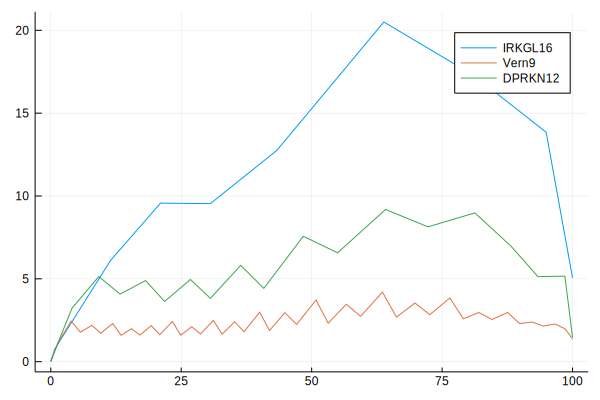

In [26]:
plot(sol1.t,steps1, label="IRKGL16")
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
plot!(sol9.t[2:end],steps9, label="Vern9")
steps8 =sol8.t[2:end]-sol8.t[1:end-1]
plot!(sol8.t[2:end],steps8, label="DPRKN12")

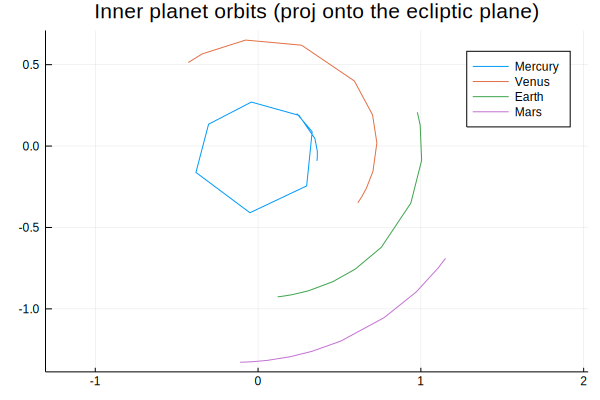

In [40]:
bodylist = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", 
            "Uranus", "Neptune", "Pluto", "Moon", "Ceres", "Pallas", "Vesta", 
             "Iris", "Bamberga"]

ulist0 = sol1.u
tlist0 = sol1.t


pl = plot(title="Inner planet orbits (proj onto the ecliptic plane)", 
          aspect_ratio=1)

for j = 2:5
# xlist  = map(u->u[2,1,j], ulist0)
# ylist  = map(u->u[2,2,j], ulist0)
 xlist  = map(u->u[1,1,j], ulist0)
 ylist  = map(u->u[1,2,j], ulist0)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end    


plot(pl)

In [11]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialNBody15(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

ΔE1 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol1.u)./E0.-1
ΔE9 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol9.u)./E0.-1
ΔE8 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol8.u)./E0.-1
#ΔE21 = map(x->NbodyEnergy(BigFloat.(vcat(x[2,:],x[1,:])),Gm128), sol21.u)./E0.-1
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE9))), Float32(maximum(abs.(ΔE8))))

(3.8592838f-16, 1.6473425f-15, 1.7227276f-16)

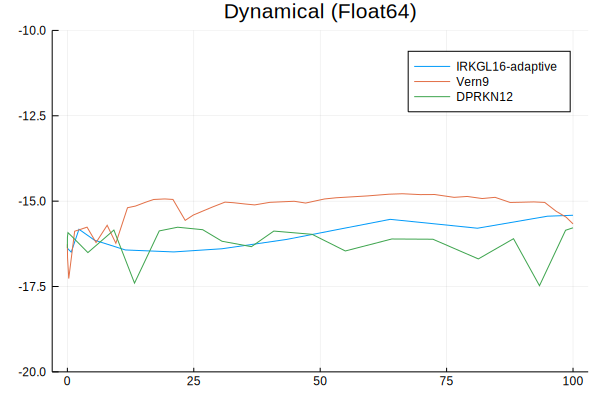

In [13]:
ylimit1=-20
ylimit2=-10
plot(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-adaptive", title="Dynamical (Float64)",
     ylims=(ylimit1,ylimit2),)
plot!(sol9.t,log10.(abs.(ΔE9)), label="Vern9",
     ylims=(ylimit1,ylimit2),)
plot!(sol8.t,log10.(abs.(ΔE8)), label="DPRKN12",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>

## Float128 Computations (OdeProblem)

In [14]:
setprecision(BigFloat, 108);

### Vern9

In [15]:
sol19 =solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20);
sol19.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  4546
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          284
Number of rejected steps:                          0

### IRKGL16 

In [16]:
(sol11,iters11,steps11) = solve(prob128,IRKGL16(), reltol=1e-20, abstol=1e-20, adaptive=true,myoutputs=true,
                             mixed_precision=false)
sol11.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  4224
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          23
Number of rejected steps:                          3

### IRKGL16 (Mixed-Precision)

In [17]:
(sol12,iters12,steps12) = solve(prob128,IRKGL16(),reltol=1e-20, abstol=1e-20,adaptive=true,myoutputs=true,
                              mixed_precision=true,low_prec_type=Float64)
sol12.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  1286
Number of function 2 evaluations:                  10440
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          23
Number of rejected steps:                          3

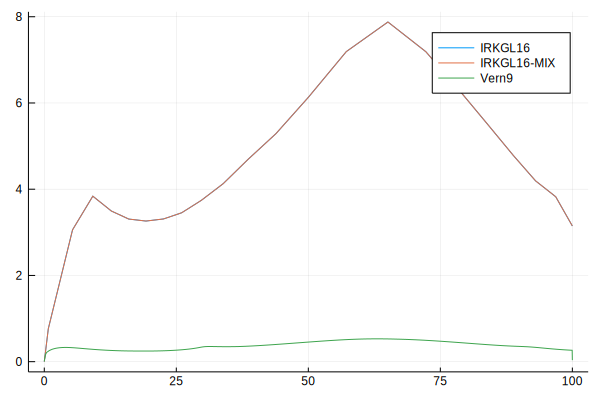

In [19]:
plot(sol11.t,steps11, label="IRKGL16")
plot!(sol12.t,steps12, label="IRKGL16-MIX")
steps19 =sol19.t[2:end]-sol19.t[1:end-1]
plot!(sol19.t[2:end],steps19, label="Vern9")

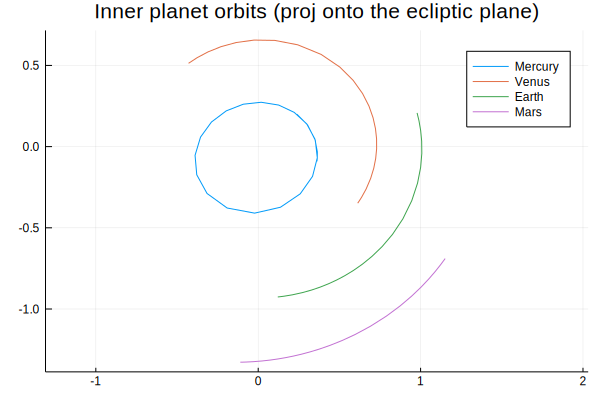

In [18]:
ulist0 = sol11.u
tlist0 = sol11.t

pl = plot(title="Inner planet orbits (proj onto the ecliptic plane)", 
          aspect_ratio=1)

for j = 2:5
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end    


plot(pl)

<a href="#top">Back to the top</a>

## Float128 Computations (DynamicalODEProblem)

In [33]:
setprecision(BigFloat, 108);

### Vern9

In [34]:
sol29 = solve(probdyn128,Vern9(), reltol=1e-20, abstol=1e-20)
sol29.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  5714
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          284
Number of rejected steps:                          73

### DPRKN12

In [35]:
sol28 = solve(prob2nd128,DPRKN12(), abstol=1e-20,reltol=1e-20);
sol28.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  1601
Number of function 2 evaluations:                  95
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          92
Number of rejected steps:                          2

### IRKGL16 

In [36]:
(sol21,iters21,steps21) = solve(probdyn128,IRKGL16(), reltol=1e-20, abstol=1e-20,adaptive=true,myoutputs=true, 
                                mixed_precision=false)
sol21.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  2330
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          23
Number of rejected steps:                          3

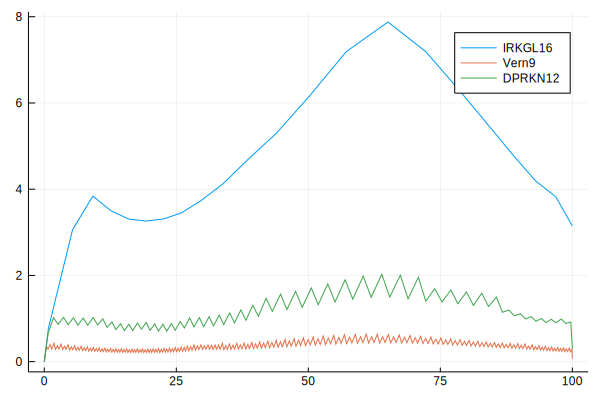

In [37]:
plot(sol21.t,steps21, label="IRKGL16")
steps29 =sol29.t[2:end]-sol29.t[1:end-1]
plot!(sol29.t[2:end],steps29, label="Vern9")
steps28 =sol28.t[2:end]-sol28.t[1:end-1]
plot!(sol28.t[2:end],steps28, label="DPRKN12")

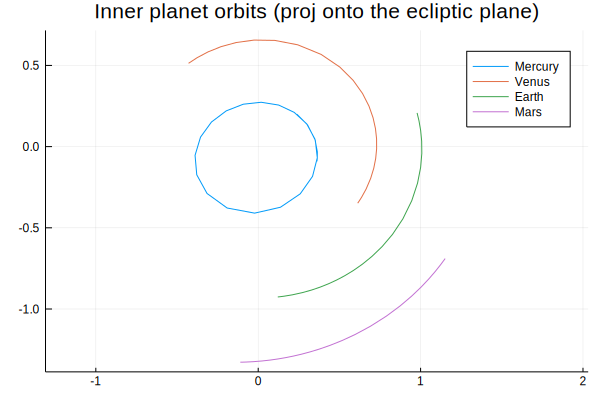

In [39]:
ulist0 = sol21.u
tlist0 = sol21.t

pl = plot(title="Inner planet orbits (proj onto the ecliptic plane)", 
          aspect_ratio=1)

for j = 2:5
# xlist  = map(u->u[2,1,j], ulist0)
# ylist  = map(u->u[2,2,j], ulist0)
 xlist  = map(u->u[1,1,j], ulist0)
 ylist  = map(u->u[1,2,j], ulist0)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end    


plot(pl)

<a href="#top">Back to the top</a>

## Error in energy

In [42]:
setprecision(BigFloat, 256)
u0256, Gm256 =InitialNBody15(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

#ΔE = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol.u)./E0.-1
ΔE11 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol11.u)./E0.-1
ΔE12 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol12.u)./E0.-1
ΔE19 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol19.u)./E0.-1
ΔE21 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol21.u)./E0.-1;
ΔE29 = map(x->NbodyEnergy2(BigFloat.(x),Gm256), sol29.u)./E0.-1;
ΔE28 = map(x->NbodyEnergy(BigFloat.(x),Gm256), sol28.u)./E0.-1;
#ΔE21 = map(x->NbodyEnergy(BigFloat.(vcat(x[2,:],x[1,:])),Gm128), sol21.u)./E0.-1
(Float32(maximum(abs.(ΔE11))),Float32(maximum(abs.(ΔE12))) ,Float32(maximum(abs.(ΔE19))),Float32(maximum(abs.(ΔE21))),Float32(maximum(abs.(ΔE29))) , Float32(maximum(abs.(ΔE28))))

(1.4961874f-23, 1.4961874f-23, 1.2046669f-23, 1.4961874f-23, 2.3414455f-23, 8.818277f-26)

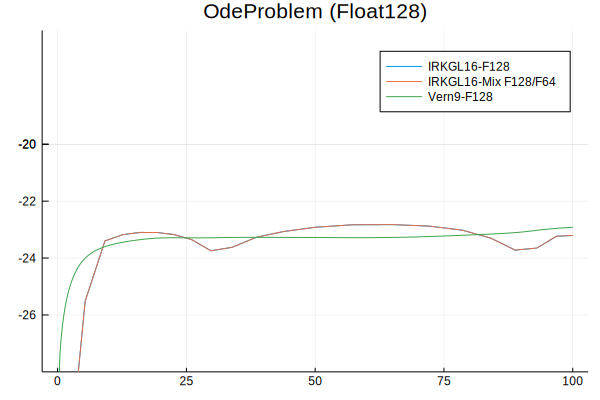

In [45]:
ylimit1=-28
ylimit2=-16
plot(sol11.t,log10.(abs.(ΔE11)), label="IRKGL16-F128", title="OdeProblem (Float128)",
     ylims=(ylimit1,ylimit2),)
plot!(sol12.t,log10.(abs.(ΔE12)), label="IRKGL16-Mix F128/F64",
     ylims=(ylimit1,ylimit2),)
plot!(sol19.t,log10.(abs.(ΔE19)), label="Vern9-F128",
     ylims=(ylimit1,ylimit2),)

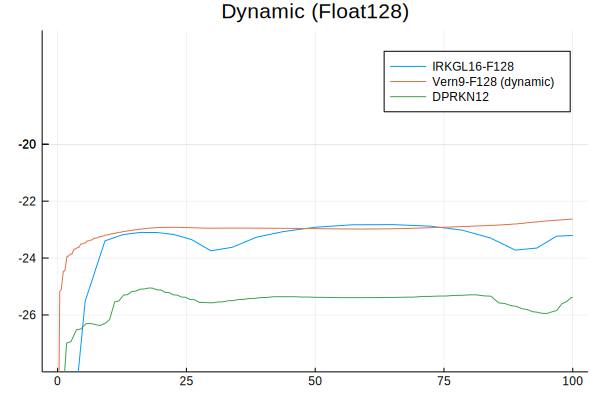

In [46]:
ylimit1=-28
ylimit2=-16
plot(sol21.t,log10.(abs.(ΔE21)), label="IRKGL16-F128", title="Dynamic (Float128)",
     ylims=(ylimit1,ylimit2),)
plot!(sol29.t,log10.(abs.(ΔE29)), label="Vern9-F128 (dynamic) ",
     ylims=(ylimit1,ylimit2),)
plot!(sol28.t,log10.(abs.(ΔE28)), label="DPRKN12",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [51]:
Threads.nthreads()

1

In [60]:
#
# Long integration !!!
#
t0=0.
t1=10^4
t1=100.

setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/nbody15_test_solF128WP.jld2" sol

#@load "./Data/nbody15_test_solF128WP.jld2" sol
test_sol = TestSolution(sol)
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  98482
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          6155
Number of rejected steps:                          0

In [61]:
u064,Gm64 =InitialNBody15(Float64)
lpp=Gm64
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=InitialNBody15(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128,;lpp=lpp)

q064=u064[2,:,:]
v064=u064[1,:,:]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[2,:,:]
v0128=u0128[1,:,:]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);

In [62]:
ux=sol.u[end]
solx=ArrayPartition(ux[2,:,:],ux[1,:,:])
test_solx = TestSolution(tspan128,[solx]);

ux=sol.u[end]
solx2nd=ArrayPartition(ux[1,:,:],ux[2,:,:])
test_solx2nd = TestSolution(tspan128,[solx2nd]);


abstols = 1.0 ./ 10.0 .^ (10:19)
reltols = 1.0 ./ 10.0 .^ (10:19)

dts=16*0.866.^(0:length(reltols)-1);

### Float64 (DynamicalProblem)

In [63]:
setups = [
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16(),:adaptive=>true, :mixed_precision=>false)
          Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false) 
]
wp2 = WorkPrecisionSet(probdyn64,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=100000000)
plot(wp2)

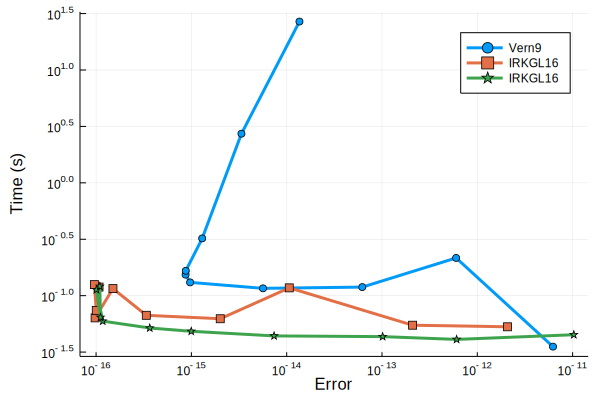

In [64]:
plot(wp2)

### Float64 (SecondOrderProblem)

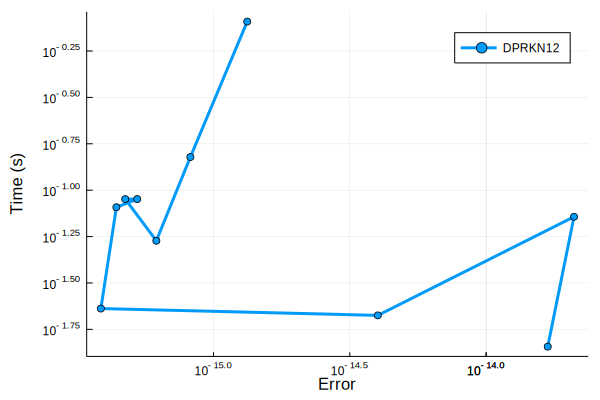

In [65]:
setups = [
          Dict(:alg=>DPRKN12())   
]
wp3 = WorkPrecisionSet(prob2nd64,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=1,maxiters=1000000)
plot(wp3)

### Plot: OdeProblem+DynamicalProblem+SecondOrderProblem (Float64)

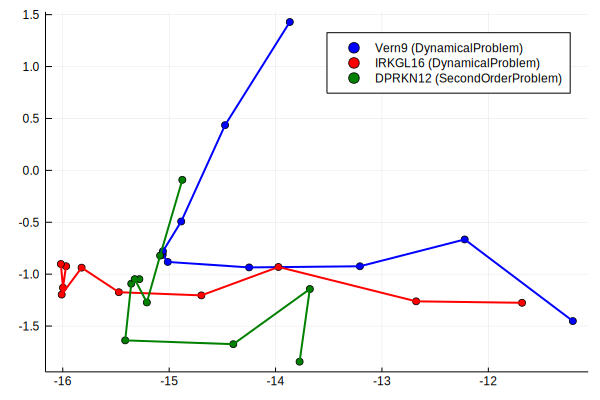

In [70]:
k=1
plot(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicalProblem)", color="blue")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="",lw=2, color="blue")
# 
k=2
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="IRKGL16 (DynamicalProblem)",color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="", lw=2, color="red")
#
k=1
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), seriestype=:scatter, label="DPRKN12 (SecondOrderProblem)",color="green")
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), label="", lw=2, color="green")

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [15]:
now()

2020-06-18T22:20:28.491

In [71]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:26)
reltols = 1.0 ./ 10.0 .^ (12:26)

dts=16*0.866.^(0:length(reltols)-1);

### Float128 (OdeProblem)

In [72]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>true,:low_prec_type=>Float64)
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,:mixed_precision=>true,:low_prec_type=>Float64)
]
wp11 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=100000000)
plot(wp11)

TaskFailedException: TaskFailedException:
InterruptException:
Stacktrace:
 [1] ^(::BigFloat, ::BigFloat) at ./mpfr.jl:592
 [2] ^ at ./promotion.jl:343 [inlined]
 [3] NbodyODE!(::Array{BigFloat,3}, ::Array{BigFloat,3}, ::Array{BigFloat,1}, ::BigFloat) at /home/joseba/Mahaigaina/PIC/PIC-2019/ikerketak/Julia Con/Softwarea/7-IRK/IRKGaussLegendre/examples/Nbody.jl:56
 [4] (::ODEFunction{true,typeof(NbodyODE!),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing})(::Array{BigFloat,3}, ::Vararg{Any,N} where N) at /home/joseba/.julia/packages/DiffEqBase/ytZvl/src/diffeqfunction.jl:248
 [5] macro expansion at /home/joseba/Mahaigaina/PIC/PIC-2019/ikerketak/Julia Con/Softwarea/7-IRK/IRKGaussLegendre/src/IRKGL16Solver.jl:457 [inlined]
 [6] (::IRKGaussLegendre.var"#65#threadsfor_fun#7"{Array{BigFloat,3},ODEFunction{true,typeof(NbodyODE!),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{BigFloat,1},Array{Array{BigFloat,3},1},Array{Array{BigFloat,3},1},Array{Array{BigFloat,3},1},Array{Array{BigFloat,3},1},Array{Array{BigFloat,3},1},Array{Bool,1},Array{BigFloat,1},Array{Int64,1},BigFloat,UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:61
 [7] (::IRKGaussLegendre.var"#65#threadsfor_fun#7"{Array{BigFloat,3},ODEFunction{true,typeof(NbodyODE!),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{BigFloat,1},Array{Array{BigFloat,3},1},Array{Array{BigFloat,3},1},Array{Array{BigFloat,3},1},Array{Array{BigFloat,3},1},Array{Array{BigFloat,3},1},Array{Bool,1},Array{BigFloat,1},Array{Int64,1},BigFloat,UnitRange{Int64}})() at ./threadingconstructs.jl:28

### Float128 (DynamicalProblem)

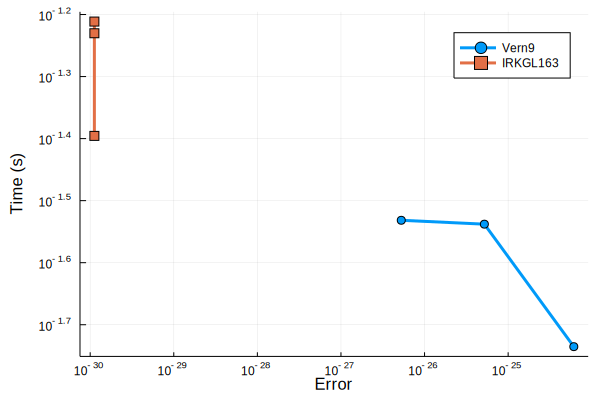

In [18]:
setups = [
          Dict(:alg=>Vern9()),
          Dict(:alg=>IRKGL16())
]
wp12 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=100000)
plot(wp12)

### Float128 (SecondOrderProblem)

In [20]:
ux=sol.u[end]
solx=ArrayPartition(ux[15:28],ux[1:14])
test_solx = TestSolution(tspan128,[solx]);

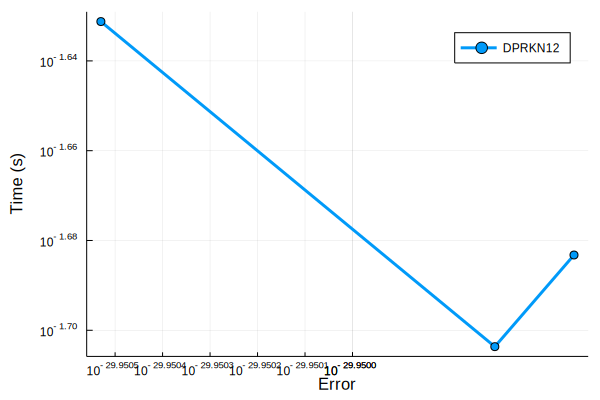

In [22]:
setups = [
          Dict(:alg=>DPRKN12())   
]
wp13 = WorkPrecisionSet(prob2nd128,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=1,maxiters=100000)
plot(wp13)

### Plot: OdeProblem+DynamicalProblem+SecondOrderProblem

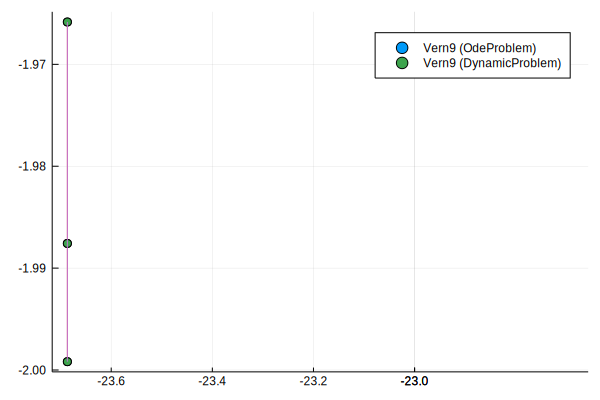

In [27]:
k=1
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="Vern9 (OdeProblem)")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="")
# 
k=1
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicProblem)")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="")


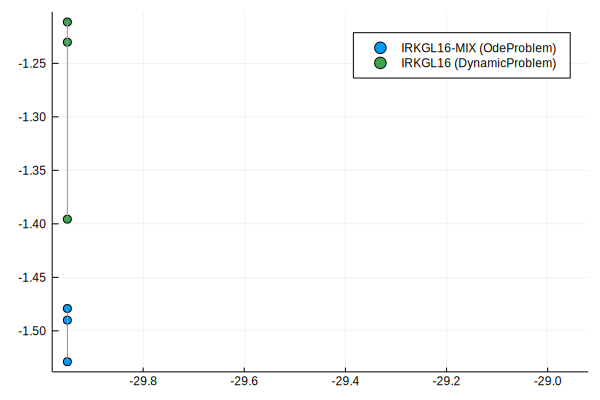

In [29]:
k=2
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16 (OdeProblem)", color="red")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="", color="red")
#
k=3
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX (OdeProblem)",  color="blue")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="", , color="blue")
# 
k=2
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="IRKGL16 (DynamicProblem)",  color="green")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="", color="green")

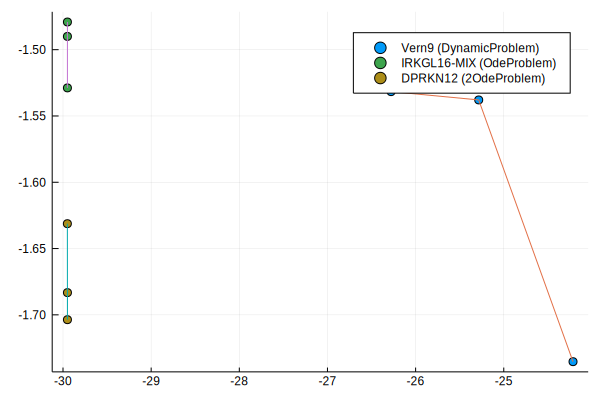

In [31]:
k=1
plot(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicProblem)")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="")
#
k=3
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX (OdeProblem)")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="")
#
k=1
plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), seriestype=:scatter, label="DPRKN12 (2OdeProblem)")
plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), label="")

<a href="#top">Back to the top</a>

In [26]:
now()

2020-06-18T22:23:06.376